In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv("https://raw.githubusercontent.com/LyJacky/stocks/4802f4e0f139ee0568afbad309086d90c78a53b7/all_stocks_5yr.csv")


2022-11-20 20:44:20.716761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df1 = df.reset_index()['close']
df1 = df1[0:1259]
df1

0       14.75
1       14.46
2       14.27
3       14.66
4       13.99
        ...  
1254    53.88
1255    52.10
1256    49.76
1257    51.18
1258    51.40
Name: close, Length: 1259, dtype: float64

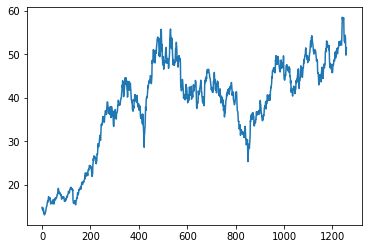

In [75]:
plt.plot(df1)

In [5]:
# scales the close values between the values 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[0.03806381],
       [0.03168317],
       [0.02750275],
       ...,
       [0.80836084],
       [0.83960396],
       [0.84444444]])

In [77]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [78]:
import numpy
# convert an array of values into a dataset matrix
# 100 tie step means that the number of day entries
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [79]:
# reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [80]:
# last one says one feature.
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [82]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
12/12 [==============================] - 8s 199ms/step - loss: 0.0981 - val_loss: 0.0317
Epoch 2/100
12/12 [==============================] - 1s 93ms/step - loss: 0.0134 - val_loss: 0.0048
Epoch 3/100
12/12 [==============================] - 1s 95ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 4/100
12/12 [==============================] - 1s 97ms/step - loss: 0.0052 - val_loss: 0.0070
Epoch 5/100
12/12 [==============================] - 1s 95ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 6/100
12/12 [==============================] - 1s 93ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 7/100
12/12 [==============================] - 1s 94ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 8/100
12/12 [==============================] - 1s 96ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/100
12/12 [==============================] - 1s 98ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/100
12/12 [==============================] - 1s 94ms/step - loss: 0.0031 - val_loss: 0.003

In [83]:
import tensorflow as tf


In [84]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 22ms/step


In [85]:
#  tranforms the scaled values back to the original
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [86]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

38.36836262125126

In [87]:
math.sqrt(mean_squared_error(ytest,test_predict))


46.28699960457477

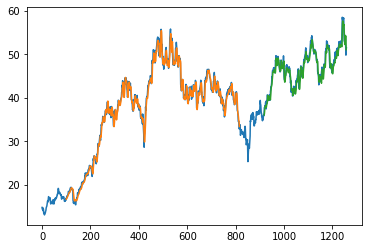

In [88]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
